# Classifying Data with Logistic Regression in Python

## Project Objective
The purpose of this project is to predict if a student will pass their exams based on an average pass rate of 60% (60% and above = pass below 60% is a fail) as this is the minimum requirement at prestigious Universities . The predictors are gender, ethnicity, preparation, lunch and parent’s education. The response is Year Result (pass or fail).

### Data Source
Students Performance in Exams Dataset source information

https://www.kaggle.com/datasets/spscientist/students-performance-in-exams/code?datasetId=74977&sortBy=voteCount&language=Python

The dataset contains 1,000 records and 8 fields

## Importing the Python Packages

import the required Python packages.

In [1]:
import pandas as pd # used to "tidy" up and manipulate our data
import numpy as np # used for matrix and numerical calculations; foundation of pandas
from scipy import stats # contains stats functions and is used to visualise probability distributions
from scipy.stats import norm 
from scipy.stats import sem # Standard error of mean
import matplotlib.pyplot as plt # used for visualisations
%matplotlib inline
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR') # error handling
import seaborn as sns # a more user-friendly library used for visualisations
sns.set_theme(rc={'figure.figsize':(8,6)})
import statistics
# import model and matrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

## 1. Collect the Data

Import the data into a dataframe called `dfR`.

In [2]:
df = pd.read_csv("C:/Users/ke337467/OneDrive - Oxfordshire County Council/Data Scientist Apprenticeship/Module Portfolio - Data Science Professional Practice/Exam Performance Logistic Regression/StudentsPerformance.csv")

To verify that the import worked as expected, preview the data using the `head()` method.

In [3]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## 2. Tidy up the data set
Check the data set for any missing data

In [4]:
df.isnull().sum(axis=0)

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

### 2.1.1 Calculate the  grade point average (GPA)

In [5]:
df['GPA'] = df[['math score', 'reading score', 'writing score']].mean(axis=1).round(2)
df['Uni_GPA'] = np.where(df['GPA'] >= 60, 'Pass', 'Fail')
df = df.drop(['math score','reading score','writing score','GPA'], axis=1)

### 2.1.2. Clean up column names and variables

In [6]:
df['race/ethnicity'] = df['race/ethnicity'].str.replace('group', 'ethnic_')
df['parental level of education'] = df['parental level of education'].str.replace('degree', '')

### 2.2. Create dummy variables from categorical predictors

Create dummy variable columns for the `race/ethnicity`, `gender`, `parental level of education`, `lunch`, and `test preparation course` columns and assign them to variables. Add Pass/Fail column to the data frame and rename it to 'Result', similarly add male column and rename it 'sex' where 1 = male and 0 = female. Remove unnecessary columns from the data frame.

In [7]:
gender_data = pd.get_dummies(df['gender'], drop_first = True)
ethnicity_data = pd.get_dummies(df['race/ethnicity'], drop_first = True)
parentEd_data = pd.get_dummies(df['parental level of education'], drop_first = True)
lunch_data = pd.get_dummies(df['lunch'], drop_first = True)
prep_data = pd.get_dummies(df['test preparation course'], drop_first = True)
Uni_GPA_data = pd.get_dummies(df['Uni_GPA'], drop_first = True)
df = pd.concat([df, ethnicity_data,gender_data,parentEd_data,lunch_data,prep_data,Uni_GPA_data], axis = 1)
df.rename(columns={'none': 'no_preparation','male': 'sex','standard': 'standard_lunch'}, inplace=True)
df.drop(['gender','race/ethnicity','parental level of education','test preparation course','lunch','Uni_GPA'], axis = 1, inplace = True)

In [8]:
df.head()

,ethnic_ B,ethnic_ C,ethnic_ D,ethnic_ E,sex,bachelor's,high school,master's,some college,some high school,standard_lunch,no_preparation,Pass
0,1,0,0,0,0,1,0,0,0,0,1,1,1
1,0,1,0,0,0,0,0,0,1,0,1,0,1
2,1,0,0,0,0,0,0,1,0,0,1,1,1
3,0,0,0,0,1,0,0,0,0,0,0,1,0
4,0,1,0,0,1,0,0,0,1,0,1,1,1


 ### 2.3. Understanding the values in the variables from categorical predictors

**Note:** Only added one dummy variable less than the total number of dummy variables for the predictor. For example the `lunch` variable `standard_lunch` and not both, `standard_lunch`  and `free/reduced_lunch` was added to the data frame. 

One dummy variable is dropped to avoid perfect collinearity as every student in the data set either had a `standard lunch` or a `free/reduced lunch`. The regression intercept captures the effect of a student having the free/reduced lunch. Specifically, the estimated value of the regression intercept in the trained model is the estimated mean effect of all students who had the `free/reduced lunch`.

Source: https://timeseriesreasoning.com/contents/dummy-variables-in-a-regression-model/


The dataset has thirteen columns. Twelve - `ethnic_ B to ethnic_ E ` (4 ethnicity columns),  `bachelor's`, `high school`,  `master's`,  `some college`, `some high school`,(5 parents education columns), `Lunch`, `preparation` and  `sex` - are the predictors (or independent variables), while - `Pass` - is the response (or dependent variable).

The objective is to train a logistic regression model to predict whether a student will get into the country's more prestigious universities  based on a GPA of 60% or more based on their `ethnicity`, `sex`, `parents education`, whether they had the `standard or free lunch` at school and whether the student took any `exam preparation courses`. 
  
In `Pass`  **0** represents <span style="color:red">**fail**</span> and **1** represents <span style="color:green">**pass**.</span>  

In `sex`  **0** represents <span style="color:green">**female**</span> and **1** represents <span style="color:red">**male**.</span>

In `Lunch`  **0** represents <span style="color:green">**student had the free/reduced lunch**</span> and **1** represents <span style="color:red">**standard lunch**.</span>

In `preparation`  **0** represents <span style="color:green">**completed exam preperations course**</span> and **1** represents <span style="color:red">**none - no preperation course taken**.</span>

In `ethnic_B` to  `ethnic_E` (4 columns) **1** represents <span style="color:green">**belongs to this ethnic group**</span> and **1** represents <span style="color:red">**does NOT belong to this group**.</span>

In parents education `bachelor's` to  `some high school` (5 columns) **1** represents <span style="color:green">**parents have this education level**</span> and **1** represents <span style="color:red">** does NOT apply**.</span>

## 2. Explore the Data
  
A concise summary data structure by calling the `info()` method.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ethnic_ B         1000 non-null   uint8
 1   ethnic_ C         1000 non-null   uint8
 2   ethnic_ D         1000 non-null   uint8
 3   ethnic_ E         1000 non-null   uint8
 4   sex               1000 non-null   uint8
 5   bachelor's        1000 non-null   uint8
 6   high school       1000 non-null   uint8
 7   master's          1000 non-null   uint8
 8   some college      1000 non-null   uint8
 9   some high school  1000 non-null   uint8
 10  standard_lunch    1000 non-null   uint8
 11  no_preparation    1000 non-null   uint8
 12  Pass              1000 non-null   uint8
dtypes: uint8(13)
memory usage: 12.8 KB


There are 1,000 instances (or rows) in the dataset.

The dataset consists of 13 features (or columns) representing 5 predictor variables and 1 response variable. 

Summary statistics for the numeric features in the data by calling the describe() method.

In [10]:
df.describe()

,ethnic_ B,ethnic_ C,ethnic_ D,ethnic_ E,sex,bachelor's,high school,master's,some college,some high school,standard_lunch,no_preparation,Pass
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.190000,0.319000,0.262000,0.140000,0.482000,0.11800,0.196000,0.059000,0.226000,0.179000,0.645000,0.642000,0.71500
std,0.392497,0.466322,0.439943,0.347161,0.499926,0.32277,0.397167,0.235743,0.418448,0.383544,0.478753,0.479652,0.45164
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


### 2.1. Exam preperation vs pass rate

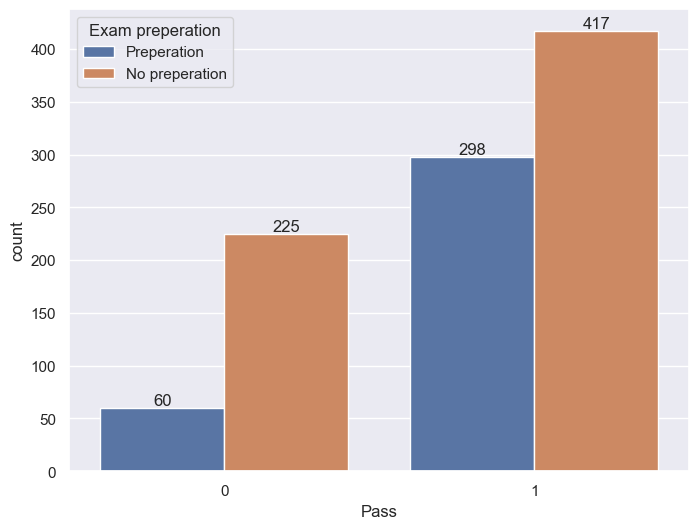

In [11]:
ax = sns.countplot(x ='Pass', data = df,hue = 'no_preparation');
plt.legend(title='Exam preperation', loc='upper left', labels=['Preperation', 'No preperation'])
for i in ax.containers:
    ax.bar_label(i,)

**Pass:**  
0 = failure (less than 60%)  
1 = Success (60% or more)   

**Note on how to add labels to multiple bars using the ax.bar_label function with a "for" loop**
sns.countplot method will return a list of sub methods.  
Use the containers method to access the text label of each bar by passing it through the ax.bar_label function.  
Use a “for” loop to iterate through the list of labels and assign each bar to a different label. 
Below is the "for" loop

<span style="color:green">
for i in ax.containers:    
    
ax.bar_label(i,)  
</span>


### 2.2. Exam pass rate by gender

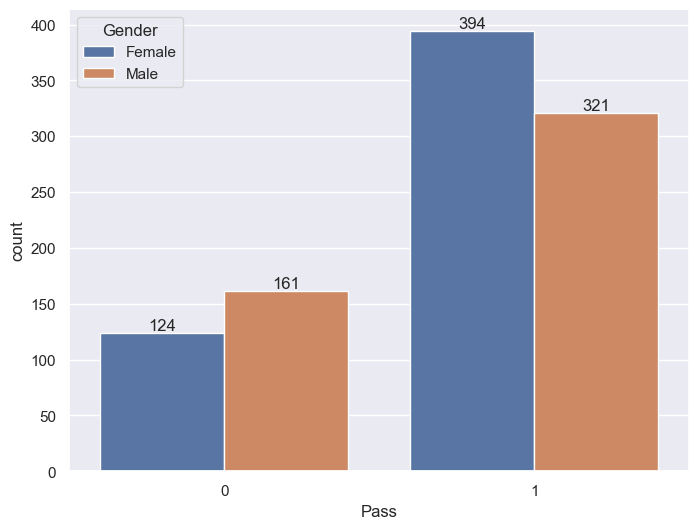

In [12]:
ax = sns.countplot(x ='Pass', data = df,hue = 'sex');
plt.legend(title='Gender', loc='upper left', labels=['Female', 'Male'])
for i in ax.containers:
    ax.bar_label(i,)

**Pass:**  
0 = failure (less than 60%)  
1 = Success (60% or more)   

### 2.3. School lunch vs pass rate

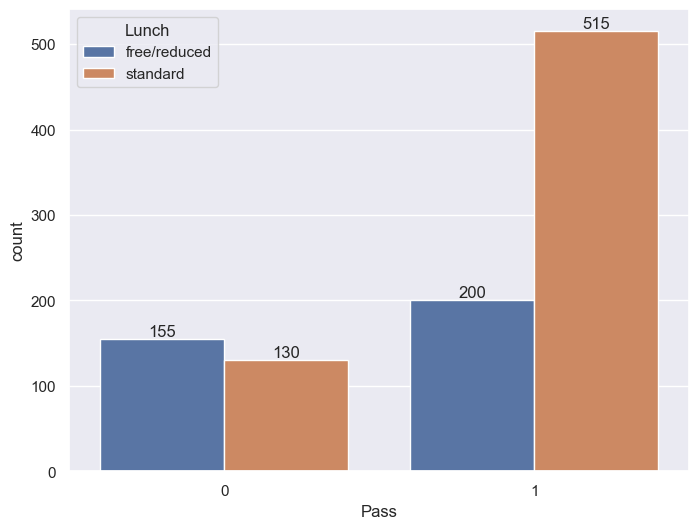

In [13]:
ax = sns.countplot(x ='Pass', data = df,hue = 'standard_lunch');
plt.legend(title='Lunch', loc='upper left', labels=['free/reduced', 'standard'])
for i in ax.containers:
    ax.bar_label(i,)

**Pass:**  
0 = failure (less than 60%)  
1 = Success (60% or more)   

## 3. Prepare the Data for the data model

#### Stage 1: separate the dependent variable
Separate the dependent variable 'y' from the independent variables. 

Create a pandas series `y` for the dependent variable.

In [14]:
y = df['Pass'] #in variable 'y' save the column ['Pass'] = response/dependent variable (categorial)
y.head()

0    1
1    1
2    1
3    0
4    1
Name: Pass, dtype: uint8

Then create a pandas DataFrame called `x` for the independent variables. In this study simply  drop the `y` [Pass] from the data frame

In [15]:
x = df.drop(['Pass'], axis  = 1)
x.head()

,ethnic_ B,ethnic_ C,ethnic_ D,ethnic_ E,sex,bachelor's,high school,master's,some college,some high school,standard_lunch,no_preparation
0,1,0,0,0,0,1,0,0,0,0,1,1
1,0,1,0,0,0,0,0,0,1,0,1,0
2,1,0,0,0,0,0,0,1,0,0,1,1
3,0,0,0,0,1,0,0,0,0,0,0,1
4,0,1,0,0,1,0,0,0,1,0,1,1


#### Stage 2: split the data into training and test sets
The  objective of this step is to split the data into training and test sets. The training set will be used to train the model, while the test set will be used to evaluate the model.  

Next, import the `train_test_split()` function from the `sklearn.model_selection` subpackage. 

In [16]:
from sklearn.model_selection import train_test_split

#### Stage 3: Setting up the train and test data

Using the `train_test_split()` function, split `X` and `y` into `X_train`, `X_test`, `y_train` and `y_test`.

Note that within the `train_test_split()` function, set:

* `train_size` to `0.7`. This means we want $70\%$ of the original data to be assigned to the training data while $30\%$ is assigned to the test data. 

* Note that the default is 0.8 so that willl split the train at 80% and test at 20%

* Stratified random sampling is used because there are fewer *No* defaults in the categorical data `loan_status`. This ensures  that the sampling refects the distribution in the categories in the test and train data sets. 

* `stratify` as `y`. split the data using a stratified random sampling approach based on the values of `y`(which is the `loan_status`data. 

* `random_state` to `123`, ensures same results every time the data is split. 

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size = 0.7,stratify = y, random_state = 123)

After the data is split, the newly created `X_train` and `X_test` data sets hold the independent variables for the training and test sets, respectively. While the `y_train` and `y_test` data sets hold the dependent variable for the training and test sets respectively.

In [18]:
x_train.shape # Note that you do not use .shape() but just .shape

(700, 12)

The result is a tuple that holds the number of rows and columns in the `x_train` dataframe.  700 out of the  1,000 instances in the exams data were assigned to the training set.

In [19]:
x_test.shape

(300, 12)

The result shows us that  300 out of the  1,000 instances in the exam data frame were assigned to the test set (neatly reflecting the 70/30% split).

## 4. Training the Logistic Regression Model

Use the `LogisticRegression` class from the `sklearn.linear_model` subpackage to train the model.

In [20]:
from sklearn.linear_model import LogisticRegression

Create the model as a LogisticRegression object

In [21]:
model = LogisticRegression()

Train the model using the fit method on the model by passing in the x_train and y_train variables.  

Note: predict_proba(x)
Probability estimates. The returned estimates for all classes are ordered by the label of classes. Returns the log-probability of the sample for each class in the model.

In [22]:
model.fit(x_train, y_train).predict_proba(x_test)

array([[0.09936684, 0.90063316],
       [0.13500635, 0.86499365],
       [0.21957109, 0.78042891],
       [0.13693943, 0.86306057],
       [0.79572702, 0.20427298],
       [0.1372689 , 0.8627311 ],
       [0.71180396, 0.28819604],
       [0.25035244, 0.74964756],
       [0.45686615, 0.54313385],
       [0.24773224, 0.75226776],
       [0.16793762, 0.83206238],
       [0.11713394, 0.88286606],
       [0.21604832, 0.78395168],
       [0.38057905, 0.61942095],
       [0.13556962, 0.86443038],
       [0.32121954, 0.67878046],
       [0.14138242, 0.85861758],
       [0.24074538, 0.75925462],
       [0.18396322, 0.81603678],
       [0.03360439, 0.96639561],
       [0.07986045, 0.92013955],
       [0.1860944 , 0.8139056 ],
       [0.31068835, 0.68931165],
       [0.32428195, 0.67571805],
       [0.22704811, 0.77295189],
       [0.3324364 , 0.6675636 ],
       [0.28034952, 0.71965048],
       [0.60099138, 0.39900862],
       [0.16793762, 0.83206238],
       [0.04759124, 0.95240876],
       [0.

The model is trained and is ready to make predictions.

## 5. Making Predictions With  Logistic Regression Model
Make a set of predictions with the test data using the logistic regression model and store the predictions in a variable called predictions.
There are 300 instances (or rows) in the test set. To predict labels for the test instances, pass the independent variables of the test set (X_test) to the predict() method of the model.

In [23]:
predictions = model.predict(x_test)

## 6. Measuring the Performance of a Logistic Regression Machine Learning Model

*scikit-learn* has an excellent built-in module called classification_report that simplifies measuring the performance of a classification model.

In [24]:
from sklearn.metrics import classification_report

Use the classification report module to calculate the performance metrics for the logistic regression model

In [25]:
classification_report(y_test, predictions)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.61      0.26      0.36        86
           1       0.76      0.93      0.84       214

    accuracy                           0.74       300
   macro avg       0.68      0.60      0.60       300
weighted avg       0.72      0.74      0.70       300



To evaluate how accurate the model is, pass the test data (`x_test` and `y_test`) to the `score() method` of the model.  

In [26]:
model.score(x_test, y_test)

0.74

The output 0.74 shows that the model is able to correctly predict 8 out of ten (or 74%) of the labels in the test set

In [27]:
print(f'Accuracy Score: {accuracy_score(y_test,predictions)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, predictions)}')
print(f'Area Under Curve: {roc_auc_score(y_test, predictions)}')
print(f'Recall score: {recall_score(y_test,predictions)}')

Accuracy Score: 0.74
Confusion Matrix: 
[[ 22  64]
 [ 14 200]]
Area Under Curve: 0.5951966963703543
Recall score: 0.9345794392523364


### 6.1. Confusion Matrix

The accuracy of a model only gives us a one-dimensional perspective of performance. To get a broader perspective, generate a confusion (or error) matrix of the model's performance. 
  
The confusion matrix clarifies the model output which can be evaluated against the test data. Next step is to interpret the model and use the model coefficients.
  
Import the `confusion_matrix` function from the `sklearn.metrics` subpackage.

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Pass the dependent variable from the test set (which are the actual labels) and the model's predicted labels to the `confusion_matrix()` function.

1) The first argument to the confusion matrix is y_test which are the actual labels.
2) The second argument to the confusion matrix is model.predict(x_test) which are the predicted labels 
3) The output is an array the array that we get is a 2 x 2 array that shows how many instances the model predicted correctly.
4) The confusion matrix is shown in the image below which shows for the first tuple (row 1) 3 true negatives 1 false positive.
5) For the seond tuple (row 2) 0 false negatives 5 true positives.

In [29]:
cm = confusion_matrix(y_test,predictions)
cm

array([[ 22,  64],
       [ 14, 200]], dtype=int64)

The result is a $ 2\times 2$ array that shows how many instances the model predicted correctly or incorrectly as either `Yes` or `No`. The confusion matrix is illustrated as follows:

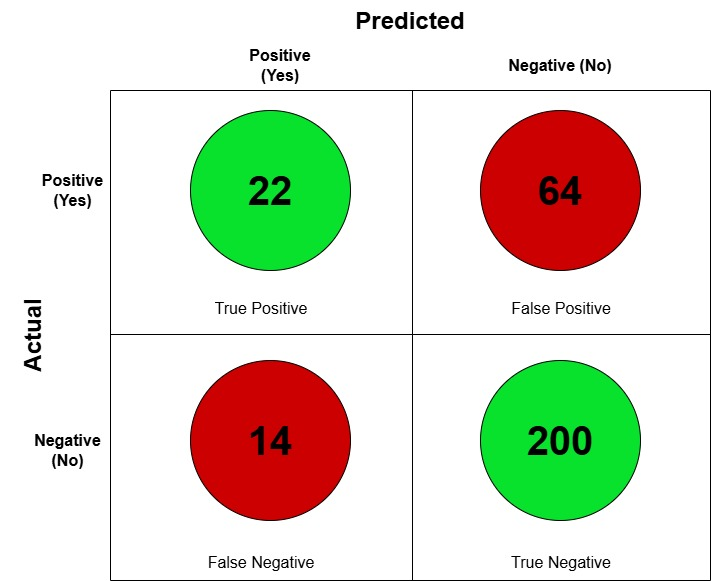

The first row of the matrix shows that of the $300$ instances, the model correctly predicted $22$ of them as `Yes` but incorrectly predicted $64$ as `Yes`when they should have been `No`. The second row of the matrix shows that of the $300$ instances the model correctly predicted $200$ as `No` but incorrectly predicted 14 false negatives.  

Correct predictions:   200 + 22 = 222 <span style="color:green">**(74% of predictions correct)**.</span>  

Incorrect predictions: 64 + 14 =  78 <span style="color:red">**(26% of predictions incorrect)**.</span>  

Total Predictions:             = 300

### 6.2. Accuracy
Accuracy measures how often the model is correct.  

In [30]:
Accuracy = metrics.accuracy_score(y_test,predictions)
Accuracy

0.74

Accuracy is 74%

### 6.3. Precision
Of the positives predicted, what percentage is truly positive  

In [31]:
Precision = metrics.precision_score(y_test,predictions)
Precision

0.7575757575757576

Precision is 75%

### 6.4. Sensitivity (Recall)
Of all the positive instanes, what percentage are predicted positive?
  
Sensitivity (Recall) measures how the model is at predicting positives.
  
True Positive / (True Positive + False Negative)

In [32]:
Sensitivity = metrics.recall_score(y_test,predictions)
Sensitivity

0.9345794392523364

  Sensitivity is 93%

### 6.5 Specificity
Measures how good the model is at prediciting negative results (essentially the opposite of recall)

True Negative / (True Negative + False Positive)

In [33]:
Specificity = metrics.recall_score(y_test,predictions, pos_label=0)
Specificity

0.2558139534883721

Specificity is 26%

### 6.6. F-score
F-score is the "harmonic mean" of precision and sensitivity.  

Considers both false positive and false negative cases  
  
2 * ((Precision * Sensitivity) / (Precision + Sensitivity))  

This score does not take into consideration the True Negative values.

In [34]:
F1_score = metrics.f1_score(y_test,predictions)
F1_score

0.8368200836820084

F1_score = 84%

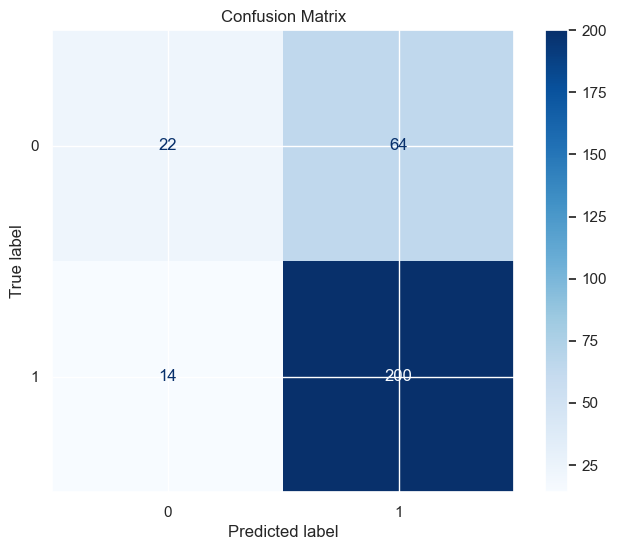

In [35]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### 6.7. Variables and the coefficients

In [36]:
pd.DataFrame(zip(x_train.columns, np.transpose(model.coef_)), columns=['features', 'coef']) 

,features,coef
0,ethnic_ B,[0.3559202667360948]
1,ethnic_ C,[0.4556373474102654]
2,ethnic_ D,[0.8182082434945347]
3,ethnic_ E,[1.0869304454920818]
4,sex,[-0.44583382499676144]
5,bachelor's,[0.3352425753042841]
6,high school,[-0.5916591900712315]
7,master's,[0.5521009315444951]
8,some college,[0.08702799057496872]
9,some high school,[-0.640389424720472]


 ### Breakdown of the coefficient results and associated p-values

In [37]:


print("Training set score: {:.3f}".format(model.score(x_train,y_train)))
print("Test set score: {:.3f}".format(model.score(x_test,y_test)))

import statsmodels.api as sm
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary())

Training set score: 0.751
Test set score: 0.740
Optimization terminated successfully.
         Current function value: 15.163567
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Pass   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      988
Method:                           MLE   Df Model:                           11
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:                     inf
Time:                        10:58:53   Log-Likelihood:                -15164.
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ethnic_ B            0.8917      0.229      3.8

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


# END